# Bootstrap sampling

In [1]:
import xarray as xr
import numpy as np
import sys
import random
from scipy import stats
import glob
from resampling import _resample_iterations_idx
from definitions import * # imports all functions from definitions.py

xr.set_options(keep_attrs = True, display_style = 'html')  # Attributes of DataArrays will be kept through operations.

alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/PW_GW_analysis/'
dir_path = '/home/hochatmstud/bene/'

In [2]:
def g_kde(y, x):
    """Firstly, kernel density estimation of the probability density function of randomized anomalies.
    Secondly, evaluates the estimated pdf on a set of points.
    
    Args:
        y (np.array): datapoints to estimate from (randomized anomalies)
        x (np.array): datapoints to be evaluated (composite values)
    Returns:
        np.array: the estimated pdf on composite values
    """
    print(y)
    mask = np.isnan(y)
    kde = stats.gaussian_kde(y[~mask])
    return kde(x)

In [3]:
station = 'Leipzig'

In [4]:
# Parameters
station = "CMOR"


## Wind measurements

In [5]:
ds_wind = read_group('wind',station)

u = read_var(ds_wind,'u0')
v = read_var(ds_wind,'v0')

u_anomalie = anomalie('dayofyear',u)

v_anomalie = anomalie('dayofyear',v)

sea_u = sea(40,station,u)
sea_u_anomalie = sea(40,station,u_anomalie)

sea_v = sea(40,station,v)
sea_v_anomalie = sea(40,station,v_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
#var = sys.argv[1] # ta, ua ; input variable
time_scale = sys.argv[2] # 20 or 30 ; input timescale
its = 10000 # 10000 ; number of samples
#what = sys.argv[4] # anomalies ; what kind of anomalies
#DJF_bool = sys.argv[5] # DJF only (bool)
rechunk = True # allows rechunking in xr.apply_ufunc

if station == 'Leipzig':
    size = 7
elif station == 'Esrange':
    size = 11
elif station == 'Sodankyla':
    size = 4
elif station == 'Sodankyla_Kiruna':
    size = 11
elif station == 'CMOR':
    size = 9
elif station == 'RioGrande':
    size = 4
elif station == 'Davis':
    size = 7

line_width = 5

In [7]:
#u_anomalie
u_anomalie['name'] = 'statistical significance'

### for-loop via the lags

In [8]:
u_anomalie = u_anomalie.sel(alt=slice(80,100)).dropna('time')

In [9]:
sea_u_anomalie = sea_u_anomalie.sel(alt=slice(80,100)).dropna('days')

In [10]:
p = []

for lag in range(-40,41,1):
    #print(comp_name, size)
    # samples generation (loaded from external function)
    rnd_arr = _resample_iterations_idx(u_anomalie, 
                                    its, 'time', replace=True, chunk=False, dim_max = size) 
    #print(rnd_arr)
    print("".ljust(line_width)+'{} samples generated'.format(its))
    ## load of composite dataarray
    #comp_file = f'{root_path}composites_woSSW{w_clim}/{var}_{what}_comp_{comp_name}_{time_scale}days.nc'
    #ds_comp = xr.open_dataarray(comp_file)*factor
    #print("".ljust(line_width)+'{} opened'.format(comp_file))
    
    # statistical significance calculation (vectorized g_kde)
    da_kde = xr.apply_ufunc(g_kde, rnd_arr, sea_u_anomalie.sel(days=lag),\
                       input_core_dims=[['iteration'], []],\
                       vectorize=True, dask='parallelized',\
                       exclude_dims=set(("iteration",)),  \
                       output_core_dims=[[]], \
                       output_dtypes=[sea_u_anomalie['u0_mean'].dtype])
    print("".ljust(line_width)+'p-values calculated')
    # output the calculation                        
    #outfile_name = f'{dir_path}bootstrap_test_{station}_lag_{lag}.nc'
    da_kde['name'] = u_anomalie['name']
    #da_kde.to_netcdf(outfile_name)
    #print("".ljust(line_width)+'{} saved'.format(outfile_name))
    #del da_kde, rnd_arr, ds_comp
    #print()
    #da_kde.plot.scatter(y='alt', x='u0_mean')
    #da_kde.plot.scatter(y='alt', x='u0_std')
    p.append(da_kde) 

     10000 samples generated
[-3.08261234 -2.36688725  3.10771242 ...  1.58662582 -0.4873223
 -4.25690155]
[-2.9852594  -1.03044526  3.15326797 ...  0.96306168 -1.5972835
 -3.48777165]
[-2.78176675  0.11599469  3.0895098  ...  0.06844975 -2.17762459
 -3.33694444]
[-3.27081699  1.09268995  2.66797386 ... -1.4260192  -2.66484886
 -3.50078431]
[-4.31221405  1.91004085  2.18869281 ... -3.11205065 -3.30204861
 -4.01196078]
[-5.0801634   1.99172386  1.87669935 ... -4.27350286 -4.19488766
 -4.01286356]
[-5.73098652  1.59555147  1.60042484 ... -4.84601511 -5.25252247
 -3.93852328]
[-6.2032741   1.33930351  1.77026144 ... -4.56663399 -6.9929616
 -3.64345792]
[-6.35811683  0.92716095  2.11614379 ... -3.67133374 -7.72919322
 -3.09574959]
[-6.55149101  0.11251021  2.50166667 ... -2.73229575 -8.08281454
 -1.32752042]
[-6.82608047 -0.54886234  2.20728758 ... -1.57270016 -7.08980392
  0.02011846]
[-3.08261234 -2.36688725  3.10771242 ...  1.58662582 -0.4873223
 -4.25690155]
[-2.9852594  -1.03044526  3

     10000 samples generated
[-0.3226491   0.67205882 -7.11405229 ...  6.93413194  1.07731618
  2.77409722]
[-0.32652574  0.33457516 -6.43617647 ...  5.78849877  2.23598856
  1.52469975]
[ 0.11821895  0.65748366 -5.37349673 ...  4.14946283  2.71749387
  1.01396855]
[ 0.71828431  1.18882353 -4.77947712 ...  2.63349673  2.43071078
  0.55085784]
[ 1.4471344   1.58973856 -4.69058824 ...  1.28394812  2.03852328
  0.39207312]
[ 1.74575368  2.09915033 -4.51441176 ...  0.44974469  1.87181985
  0.55580882]
[ 1.59684232  2.56921569 -4.79117647 ... -0.17125     1.65563113
  0.69144404]
[ 1.35681985  2.74545752 -4.71689542 ... -0.33072712  1.24222426
  1.12644608]
[ 1.72789828  2.50568627 -4.32980392 ...  0.24834559  0.53019199
  1.37218137]
[ 2.06589461  2.65702614 -3.67777778 ...  1.18704861 -0.29742851
  1.20297181]
[ 2.2884906   3.82620915 -3.01617647 ...  1.61237949 -1.14877859
  0.81514706]
[-0.3226491   0.67205882 -7.11405229 ...  6.93413194  1.07731618
  2.77409722]
[-0.32652574  0.3345751


[  1.79010825 -12.52934845   1.19227941 ...   1.73188317   0.95550041
  -1.15688017]
[  2.00395221 -10.47561275  -0.04615605 ...   0.51289828   0.80081291
  -0.26416558]
[ 2.25047794 -8.34190972 -1.80102328 ... -0.53006127  0.43928717
  0.06565795]
[ 2.25522672 -6.35291054 -3.60066993 ... -1.1626634  -0.10636029
  0.26844444]
[ 2.566346   -4.61135825 -5.24815155 ... -1.79582312 -0.53148693
  0.57348802]
[ 2.60763276 -3.24892974 -6.34661969 ... -1.99401144 -1.04186275
  0.80235076]
[ 2.79409109 -2.12203431 -6.26279616 ... -2.61491626 -1.78115605
  0.77684532]
[ 2.89773284 -0.79526144 -6.04154412 ... -2.94719771 -2.81825572
  1.10047277]
[ 3.16056168  0.73528799 -5.48476307 ... -2.29891748 -3.29823734
  1.38492593]
[ 3.014904    1.82260825 -4.83090891 ... -0.98028186 -3.96719158
  0.9776122 ]
[  2.23315564 -14.47896242   2.3877982  ...   3.01152165   1.02915033
  -1.88080174]
[  1.79010825 -12.52934845   1.19227941 ...   1.73188317   0.95550041
  -1.15688017]
[  2.00395221 -10.47561275 


[ 4.86492647  1.54198529 -3.48655637 ... -0.87144608 -4.04300449
  1.34495302]
[ 4.28104371 -0.07685866 -3.02229167 ... -1.46118873 -2.81791258
  1.23363154]
[ 3.62941789 -1.48556168 -2.77972631 ... -1.85967933 -1.9473366
  0.77354371]
[ 2.91780229 -2.16069649 -1.98504289 ... -2.33946283 -0.97281863
  0.458125  ]
[ 2.27903186 -2.64058619 -1.19255719 ... -2.41362337  0.17020425
  0.2446732 ]
[ 1.57331291 -3.20156454 -0.47091503 ... -2.89638889  0.69980801
 -0.12451389]
[ 0.81383374 -3.43606413 -0.08963848 ... -3.15591912  1.19072508
 -0.35982843]
[-0.26585172 -3.65465686  0.16331904 ... -3.25394199  0.71198938
 -0.70425858]
[-0.8444281  -3.21940768  0.20568832 ... -3.17396446  0.24504698
 -1.87674428]
[-1.38596405 -2.4942402   0.84834967 ... -3.1783558  -0.054375
 -2.61256944]
[ 4.97792688  4.21665033 -3.59889297 ... -0.51080474 -5.62108047
  0.74965891]
[ 4.86492647  1.54198529 -3.48655637 ... -0.87144608 -4.04300449
  1.34495302]
[ 4.28104371 -0.07685866 -3.02229167 ... -1.46118873 -

     10000 samples generated
[ 1.51155025  3.3714134   0.38179126 ...  3.56975082 -2.211346
 -2.71989379]
[ 0.9698366   3.1314134  -0.33478145 ...  4.33300245 -3.23095792
 -3.38398284]
[ 0.96142157  2.48682802 -0.79090686 ...  4.74905433 -4.04276757
 -3.19718546]
[ 1.02890931  2.07647876 -1.67321283 ...  4.51698938 -4.4014134
 -2.23871528]
[ 0.96137051  1.54403391 -2.33736315 ...  3.79112541 -4.20252247
 -0.94449346]
[ 0.81698325  1.17238358 -3.26925654 ...  2.78262868 -3.65300858
  0.34035539]
[ 0.44849877  1.10825776 -3.94316789 ...  1.81877451 -2.84050245
  1.53906454]
[-0.20061887  1.26507149 -4.96590482 ...  0.88280025 -2.21668709
  2.32272059]
[-1.12330882  1.15238971 -6.06771855 ... -0.49918913 -1.19490605
  2.76369077]
[-1.90591095  1.06708129 -6.74625204 ... -1.8522835  -0.37981209
  3.0403268 ]
[-1.71008783  1.13654616 -6.9251348  ... -2.87000204  0.93968954
  3.11787786]
[ 1.51155025  3.3714134   0.38179126 ...  3.56975082 -2.211346
 -2.71989379]
[ 0.9698366   3.1314134  -0.

     10000 samples generated
[-7.23978554  1.58261234  3.61711601 ... 10.28675858 -3.6293607
  3.80189542]
[-6.48739788  0.69192198  5.48747753 ...  8.87865809 -3.82033701
  3.76898693]
[-5.66592729 -0.72080065  6.44565359 ...  6.90430556 -3.94025123
  3.09879085]
[-4.89036969 -2.19132761  6.55141953 ...  4.69451797 -3.86345384
  2.65905229]
[-3.70928309 -3.55207516  6.8131393  ...  2.81159722 -3.93786152
  2.10493464]
[-2.71153799 -4.47057802  7.05179943 ...  1.51333333 -3.99073734
  1.82222222]
[-2.11542688 -5.45976103  7.1873509  ...  0.20637868 -3.7632067
  1.62405229]
[-2.06519608 -6.24847222  7.10730596 ... -1.5128799  -3.56531863
  1.13506536]
[-1.81480801 -7.46269812  6.71847835 ... -3.46348243 -3.21862541
  0.14591503]
[-1.45849265 -8.07057598  6.48437092 ... -5.12065972 -2.52811479
 -1.11013072]
[-0.91502655 -8.49611111  6.718221   ... -6.43723652 -1.99058007
 -1.59352941]
[-7.23978554  1.58261234  3.61711601 ... 10.28675858 -3.6293607
  3.80189542]
[-6.48739788  0.69192198  

     10000 samples generated
[  2.65236928  -0.74510008   5.34190564 ...  -0.08813725  -0.77548815
 -13.22372345]
[  2.41074755  -0.30425041   4.8203942  ...  -0.03916054  -0.68163399
 -11.46848243]
[ 2.06939951  0.27931168  4.38771446 ... -0.25118873 -0.8502308
 -9.77256332]
[ 1.4841442   0.59612949  4.19035335 ... -0.59580474 -1.01563317
 -8.19079044]
[ 0.97134191  0.56640319  3.9990768  ... -0.81002859 -1.07536969
 -6.54024918]
[ 0.60885008  1.01452002  2.86352124 ... -0.71288603 -1.50224265
 -4.75073529]
[ 0.58722835  2.25699551  2.66321691 ... -0.77770629 -2.03348448
 -3.27828431]
[ 0.8835192   3.31304943  2.38249387 ... -1.01513685 -2.28010212
 -2.71580882]
[ 1.2103799   3.63548815  2.00387051 ... -1.54823734 -2.02808619
 -2.62696487]
[ 1.64599265  2.84625     2.31369077 ... -1.82962623 -1.18827206
 -2.45661152]
[ 1.69325163  1.39973652  2.46287173 ... -1.61969567 -0.6028942
 -2.40972631]
[  2.65236928  -0.74510008   5.34190564 ...  -0.08813725  -0.77548815
 -13.22372345]
[  2.41

     10000 samples generated
[ 2.949904   -1.33841095  1.673654   ... -1.45030025 -3.5881107
 -6.84363562]
[ 2.66755719 -0.16056373  2.09777165 ... -1.45329453 -2.67413603
 -5.5883558 ]
[ 3.02141953  1.55406863  2.36320057 ... -1.04761029 -1.53594975
 -4.33463644]
[ 3.25795956  2.68556577  2.3319281  ... -0.59007557 -1.1951348
 -2.90423407]
[ 3.5773509   4.21159722  2.30328023 ... -0.11145425 -1.37705474
 -1.68576185]
[ 3.80142361  5.41843342  2.81081291 ...  0.69808007 -1.71819036
 -0.26550449]
[ 4.50437296  5.74284926  3.27258578 ...  1.5985866  -2.35696283
  0.44464461]
[ 5.11034518  5.70730801  3.61825368 ...  2.44393995 -2.70436479
  1.04476307]
[ 5.64941176  5.93993668  3.48482435 ...  3.39035335 -2.37472018
  1.18131944]
[ 6.43439747  5.9573652   3.3370098  ...  4.08607639 -2.68824142
  0.89391136]
[ 7.33116013  6.50308619  3.53824959 ...  4.69717933 -2.9991973
 -0.05752247]
[ 2.949904   -1.33841095  1.673654   ... -1.45030025 -3.5881107
 -6.84363562]
[ 2.66755719 -0.16056373  2


[-3.93721405  3.96521242 -6.47558824 ...  1.55022672 -0.8953268
 -3.92753064]
[-5.18420547  3.35627451 -6.03787582 ...  0.38159518 -0.80630719
 -3.53935253]
[-5.94250204  2.30920547 -5.13676471 ... -0.79763685 -0.88183007
 -2.68376634]
[-6.46520833  1.1235866  -4.21062092 ... -1.61227941 -1.05944444
 -1.85908497]
[-6.87364788  0.01269812 -3.00715686 ... -2.15419322 -1.56228758
 -0.97205882]
[-6.86578431 -0.78538603 -1.67486928 ... -2.39620915 -2.12676471
 -0.63856413]
[-6.54019199 -1.67294935 -0.15150327 ... -2.51614788 -2.70019608
 -0.54471609]
[-5.82981005 -2.34666462  0.84035948 ... -2.27093954 -3.41676471
 -0.04844567]
[-5.10862541 -2.72385621  1.75767974 ... -1.91836397 -3.99107843
  0.78523284]
[-3.52005719 -2.95242239  1.99147059 ... -0.59684232 -4.17238562
  1.38669118]
[-2.54728145  4.23984886 -6.52885621 ...  2.35413399 -1.05196078
 -3.79524101]
[-3.93721405  3.96521242 -6.47558824 ...  1.55022672 -0.8953268
 -3.92753064]
[-5.18420547  3.35627451 -6.03787582 ...  0.38159518 

     10000 samples generated
[ 5.51366013 -1.11078431  3.73800245 ...  0.06123979  1.70105801
 -2.79905842]
[ 4.49086601 -2.38562092  3.1351491  ...  0.58618056 -0.0760866
 -3.2682598 ]
[ 2.96650327 -3.38578431  3.10797794 ...  0.81554534 -1.76814951
 -3.11170956]
[ 1.59653595 -4.21957516  3.60285335 ...  1.23171977 -3.40056168
 -2.4234518 ]
[ 0.56209967 -4.62856209  4.13341299 ...  1.0290625  -4.92825368
 -1.43801062]
[-0.62129085 -5.03382353  4.73341299 ...  0.98844567 -6.73185866
  0.39396038]
[-1.96060866 -5.51395425  5.18710989 ...  1.00718342 -8.04952614
  2.45096201]
[-3.07131332 -5.72934641  5.73262459 ...  0.74550245 -8.70967729
  4.22382149]
[-3.93646855 -6.06728758  6.38478758 ...  1.0240094  -8.53149101
  5.81426879]
[-4.27544935 -5.91297386  7.08902982 ...  0.98032271 -7.35876838
  6.94689338]
[-4.60387051 -5.76784314  7.02522672 ...  1.24254902 -6.09260417
  8.22363154]
[ 5.51366013 -1.11078431  3.73800245 ...  0.06123979  1.70105801
 -2.79905842]
[ 4.49086601 -2.38562092

     10000 samples generated
[-3.84688113  7.76107843  5.73924837 ... -4.33501634 -2.04549224
  4.07286152]
[-3.43609681  7.70960784  4.71611111 ... -4.31218137 -0.89348448
  3.53025327]
[-3.17947304  7.47849673  3.74071895 ... -3.81186275  0.16129493
  2.96644812]
[-3.19895425  7.33568627  2.88379085 ... -3.82651552  1.19860294
  2.83775531]
[-3.246779    6.44401961  2.58633987 ... -3.76641544  1.94700163
  2.59828023]
[-3.14698734  5.01        2.42173203 ... -3.18258783  2.83926062
  2.20565972]
[-3.2816442   3.15078431  2.18163399 ... -2.85167075  3.81382761
  2.23616217]
[-3.76569444  1.90222222  1.54954248 ... -3.04706904  4.43713031
  2.62640931]
[-3.94686275  1.31026144  0.64869281 ... -2.90982843  4.55304126
  3.26343342]
[-3.90183619  0.00820261  0.23813725 ... -3.13933211  4.99472631
  4.28209559]
[-4.26506944 -1.36261438  0.23183007 ... -3.41514706  4.76093546
  5.45135008]
[-3.84688113  7.76107843  5.73924837 ... -4.33501634 -2.04549224
  4.07286152]
[-3.43609681  7.7096078


[ 3.96352941 -2.30708129  0.51333333 ... -6.57026144 -2.12311275
 -2.32848652]
[ 3.90493464 -3.20785948 -1.83735294 ... -5.93660131 -2.34950776
 -1.47624387]
[ 4.48558824 -3.61811887 -3.60313725 ... -5.29366013 -2.1622549
 -0.54769199]
[ 5.15558824 -3.59770629 -4.57075163 ... -4.57408497 -1.25480596
  0.414279  ]
[ 5.6322549  -3.11754698 -5.23042484 ... -3.83362745 -0.2844424
  1.05399306]
[ 6.20526144 -2.33893587 -6.31712418 ... -3.07392157  0.27972835
  1.3706393 ]
[ 6.67088235 -1.75398489 -7.33068627 ... -2.21320261  1.08854779
  1.16088848]
[ 6.67944444 -1.4783558  -7.88392157 ... -1.27633987  1.85206495
  0.78100082]
[ 5.48924837 -0.81507557 -7.84026144 ...  0.08637255  2.78212827
  0.62909109]
[ 4.10003268 -0.07700368 -7.16120915 ...  1.35284314  3.39344363
  0.25657067]
[ 4.17013072 -1.43584967  2.98911765 ... -7.57650327 -1.3234518
 -2.62249796]
[ 3.96352941 -2.30708129  0.51333333 ... -6.57026144 -2.12311275
 -2.32848652]
[ 3.90493464 -3.20785948 -1.83735294 ... -5.93660131 -


[ 1.17805556 -2.024471    2.00421569 ...  5.23053922 -6.88405229
 -2.0080433 ]
[ 2.49804943 -1.94724673  2.28728758 ...  4.25751225 -6.24212418
 -2.04752451]
[ 3.54260417 -1.96022672  2.29316993 ...  2.82186887 -5.36052288
 -1.99382149]
[ 4.17687296 -1.53681373  1.78905229 ...  1.60546773 -4.43310458
 -1.80614992]
[ 4.73948325 -1.10738358  1.09614379 ...  0.41787173 -3.33571895
 -1.75921977]
[ 4.91663603 -0.63048407  0.39584967 ... -0.89178922 -2.39921569
 -1.50340686]
[ 5.19308619  0.05561887 -0.08039216 ... -1.91495915 -1.2975817
 -1.09087418]
[ 5.94747141  1.17579248 -0.58794118 ... -2.61901348 -0.61879085
 -0.75619281]
[ 6.07182394  2.36195261 -1.55493464 ... -3.60792892 -0.02179739
 -0.0342402 ]
[ 6.99426062  3.55686887 -2.06352941 ... -4.67097018  0.13578431
  1.06620507]
[-0.7357067  -1.71242239  1.57614379 ...  6.07091503 -6.76738562
 -1.74891136]
[ 1.17805556 -2.024471    2.00421569 ...  5.23053922 -6.88405229
 -2.0080433 ]
[ 2.49804943 -1.94724673  2.28728758 ...  4.25751225


[ 0.04637051  1.23206291 -4.68043096 ... -0.85594975 -6.99426266
 -6.05037786]
[-0.36177492  0.10933211 -4.24430964 ... -2.09904412 -7.33356005
 -5.59262255]
[-1.28698121 -0.72123366 -4.05218954 ... -2.85556985 -7.60402369
 -5.18537377]
[-2.1751491  -0.9931107  -3.29198325 ... -3.48103145 -7.76839665
 -4.80981413]
[-2.85161152 -1.19847426 -2.25518382 ... -3.71611111 -7.72293709
 -4.33921977]
[-3.4459518  -1.67429943 -1.09600286 ... -3.81431577 -7.24253881
 -4.39639706]
[-3.59545752 -1.73477328 -0.42684641 ... -4.33014502 -6.60552083
 -4.81012051]
[-3.59578227 -1.82408088 -0.10859273 ... -4.52187704 -5.71389093
 -5.01855188]
[-3.43345997 -1.63908701  0.17360907 ... -4.44771446 -4.68213031
 -5.31995302]
[-3.87111111 -1.36485294 -0.27309641 ... -4.47766136 -3.15224469
 -5.76081495]
[ 0.26184641  2.6698509  -4.57676879 ...  0.80202614 -6.5801348
 -6.36203636]
[ 0.04637051  1.23206291 -4.68043096 ... -0.85594975 -6.99426266
 -6.05037786]
[-0.36177492  0.10933211 -4.24430964 ... -2.09904412


[  6.76633783   1.36484681 -10.37153391 ...   3.02680556  -0.10979167
   3.56412786]
[ 5.26575572  1.10612132 -9.62300858 ...  3.20048611 -0.41533905
  2.83737949]
[ 3.83923815  0.47547181 -9.19074142 ...  3.75780842 -0.74518791
  2.22141748]
[ 2.40479984 -0.03285948 -8.86276348 ...  4.05423611 -0.99675654
  1.24016544]
[ 1.13278186 -0.20152778 -8.30359681 ...  3.9320241  -1.26531454
 -0.0805719 ]
[ 5.56576797e-03 -2.47175245e-01 -7.48438317e+00 ...  3.63564747e+00
 -7.90943627e-01 -1.35644608e+00]
[-1.09955474  0.11017974 -6.43819444 ...  3.45626021  0.17160743
 -2.2215625 ]
[-1.87042279  0.22548611 -5.86224469 ...  3.9272835   1.10408701
 -3.22052492]
[-2.21908292  0.93219363 -5.637596   ...  4.62808007  2.33626225
 -3.78776348]
[-1.61178717  1.42914216 -5.653654   ...  5.3322549   2.96910539
 -4.07860907]
[  7.7852982    1.08559028 -11.08536356 ...   3.54816176   0.44117443
   4.73535131]
[  6.76633783   1.36484681 -10.37153391 ...   3.02680556  -0.10979167
   3.56412786]
[ 5.26575


[-6.56579453  3.31728145 -4.80823734 ...  3.9382741  -6.8355719
 -2.29011029]
[-4.44950368  2.00369077 -3.55465278 ...  4.6401634  -7.04165237
 -1.70234886]
[-2.07877655  0.94570466 -1.92132353 ...  5.34234273 -7.05385008
 -0.79361315]
[ 0.35768382  0.49469363 -0.05200163 ...  6.04391544 -6.93150531
  0.24975694]
[ 2.69704044  0.2479473   2.57548611 ...  6.17602533 -6.79060253
  0.94082925]
[ 4.29704044  0.5145098   4.96797794 ...  5.8540482  -6.3976348
  1.64303309]
[ 4.94426062  0.93934028  6.98173815 ...  5.2543893  -5.57003676
  2.25099469]
[ 4.92889502  1.08405433  8.63921977 ...  4.2809375  -4.2068893
  2.99116217]
[ 4.51562704  1.29921977  9.93983252 ...  3.53157067 -2.84201593
  3.66066789]
[ 3.81192402  1.91600694 10.99833742 ...  3.05181577 -1.40918709
  4.119279  ]
[-8.29671977  4.54154208 -5.63058824 ...  2.88448938 -5.94793096
 -2.53507149]
[-6.56579453  3.31728145 -4.80823734 ...  3.9382741  -6.8355719
 -2.29011029]
[-4.44950368  2.00369077 -3.55465278 ...  4.6401634  -7

     10000 samples generated
[-3.18724265 -0.15828636 -2.26680556 ...  2.63480392  1.07521855
 -0.5027594 ]
[-3.41713644 -0.313125   -2.59970792 ...  2.24065359  0.67064338
 -0.61552083]
[-4.22871936 -0.20632761 -2.51659314 ...  2.51901961  0.96589869
 -0.81239788]
[-4.86584355 -0.05589257 -2.32789011 ...  2.92591503  1.51606209
 -1.19135008]
[-5.12973039  0.06270629 -1.52415237 ...  3.06781046  2.20951389
 -1.85803717]
[-4.86514502  0.15939747 -1.03554126 ...  2.57212418  2.46980392
 -2.41856618]
[-4.10116626  0.34452819 -0.78595588 ...  2.22718954  2.38256536
 -3.14495302]
[-3.28097426  0.91808824 -0.56229575 ...  2.6125817   1.98972426
 -3.60332721]
[-1.89892361  1.51602737 -0.4030719  ...  3.22839869  1.43361111
 -3.74596201]
[ 0.01596201  2.07646038 -0.15931985 ...  4.42281046  0.49929943
 -3.64518791]
[ 1.80355188  2.35011438  0.30983047 ...  4.66970588 -0.10975082
 -4.0341973 ]
[-3.18724265 -0.15828636 -2.26680556 ...  2.63480392  1.07521855
 -0.5027594 ]
[-3.41713644 -0.313125 

In [11]:
p_comp =  xr.concat(p, dim = 'days')
p_comp['days'] = range(-40, 40+1)
p_comp = p_comp.where(p_comp['u0_mean'] < 0.05, other = -0.05)

In [12]:
#p_comp

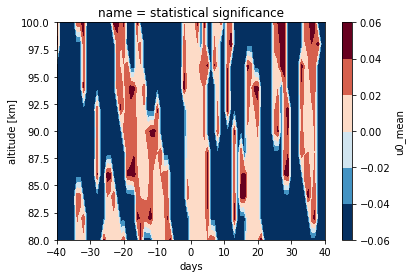

In [13]:
p_comp['u0_mean'].plot.contourf(x='days')